## Objet du programme :

Le but de ce programme est de réaliser un clustering de type de parcours à partir d'un log d'activité mentionnant :

Un identifiant

Une date associée à l'activité

Un type d'activité

## SECTION PARAMETRAGE

In [1]:
from datetime import datetime

#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns
#import dtw as dtw
#import tsfresh #TimeSeries Transformation library
import my_custom_func_TS_Clust_1 as Mcftsc
import mlflow

from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

#SET THE RANDOM SET FOR SKLEARN
#np.random.seed(0)

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
#import Parcours_Classes as PC

2023-12-14 11:33:16,163 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-12-14 11:33:16,163 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-12-14 11:33:16,165 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-12-14 11:33:16,166 INFO sqlalchemy.engine.Engine [generated in 0.00057s] ()
2023-12-14 11:33:16,168 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-12-14 11:33:16,168 INFO sqlalchemy.engine.Engine [generated in 0.00042s] ()
2023-12-14 11:33:16,170 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2023-12-14 11:33:16,171 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


In [3]:
#ML FLOW Configuration

# LAUNCH ML FLOW UI
#!mlflow server --host 127.0.0.1 --port 8080
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Set an experiment name, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("Clustering parcours_V2")
mlflow.set_experiment_tag("release.version", "0.1")

# Get Experiment Details
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")

# Launch a run into the experiment
mlflow.start_run()

Experiment_id: 715714748593750550
Artifact Location: mlflow-artifacts:/715714748593750550
Tags: {'release.version': '0.1'}
Lifecycle_stage: active


<ActiveRun: >

## IMPORT DES DONNEES

In [4]:
Create_dataset_parameters={'DS_My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
                            'DS_My_NIP_filter_2nd_date_delta_in_days': 1,
                            'DS_Site': '2',
                            'DS_Start_Window_time': '01-09-2018 00:00:00',
                            'DS_End_Window_time': '12-31-2020 00:00:00',
                            }
myouputpath='../06 - Temp_outputs/'

In [5]:
mlflow.log_params(Create_dataset_parameters)

In [6]:
Caracteristiques_Dataset=Mcftsc.Create_dataset(Create_dataset_parameters)

STEP 1.0 : Delete old Tables
2023-12-14 11:33:16,506 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-14 11:33:16,506 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-12-14 11:33:16,507 INFO sqlalchemy.engine.Engine [generated in 0.00048s] ()
2023-12-14 11:33:16,508 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-01-01 00:00:00 - Date2  = 2019-01-02 00:00:00 - launched at 2023-12-14 11:33:16.510737
2023-12-14 11:33:16,510 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-14 11:33:16,511 INFO sqlalchemy.engine.Engine  EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE_AND_DATASET_ON_2_DATES A_Actes_ICO_2018_2021_V2_TRIMED,Tmp_Py_A_Actes_Export,'2019-01-01 00:00:00','2019-01-02 00:00:00','2018-01-09 00:00:00','2020-12-31 00:00:00',2
2023-12-14 11:33:16,511 INFO sqlalchemy.engine.Engine [generated in 0.00043s] ()
2023-12-14 11:33:17,321 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.2 : Prepare_Dat

In [7]:
# Create the DataFrame
df = pd.DataFrame.from_dict(Caracteristiques_Dataset)

# Convert specified columns to dictionary
mydict = df.iloc[:, 6:].to_dict(orient='list')

# Filter dictionary to contain only float values and not lists
for key, value in mydict.items():
    if len(value) == 1 :
        mydict[key] = value[0]

mlflow.log_metrics(mydict)

## AFFICHAGE GENERAL DES DONNEES

In [8]:
#Get all actes in the Dataset

Requete = """
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  """
  
Actes_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,True) #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')
Actes_Total


2023-12-14 11:33:49,956 INFO sqlalchemy.engine.Engine 
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  
2023-12-14 11:33:49,957 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


ID_A         NIP       N_S       DD_A       DF_A       DD_M  \
0       13706147  N201702618  N1728047 2018-10-10 2018-10-10 1899-12-30   
1       13706148  N201702618  N1728047 2018-10-10 2018-10-10 1899-12-30   
2       13706149  N201702618  N1728047 2018-10-10 2018-10-10 1899-12-30   
3       13706150  N201702618  N1728047 2018-10-10 2018-10-10 1899-12-30   
4       13706151  N201702618  N1728047 2018-10-10 2018-10-10 1899-12-30   
...          ...         ...       ...        ...        ...        ...   
105799  15349173  N201203646  N2103029 2020-10-13 2020-10-13 1899-12-30   
105800  15349206  N201801476  N2055656 2020-07-13 2020-07-13 1899-12-30   
105801  15349208  N201801476  N2055656 2020-07-13 2020-07-13 1899-12-30   
105802  15349264  N201806241  N2102378 2020-10-12 2020-10-12 1899-12-30   
105803  15349552  N201203646  N2103029 2020-10-13 2020-10-13 1899-12-30   

             HD_M       DF_M       HF_M   UFX  ... AC_Asso Lc_Prix UFH UFH_L  \
0      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
1      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
2      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
3      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
4      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
...           ...        ...        ...   ...  ...     ...     ...  ..   ...   
105799 1899-12-30 1899-12-30 1899-12-30  9052  ...       0       5             
105800 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105801 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105802 1899-12-30 1899-12-30 1899-12-30  9052  ...       0       2             
105803 1899-12-30 1899-12-30 1899-12-30  9052  ...       0       2             

       Prix_Acte Cout_Acte Statut Code_Equip Site Source  
0                               H               2   NGAP  
1                               H               2   NGAP  
2                               H               2   NGAP  
3                               H               2   NGAP  
4                               H               2   NGAP  
...          ...       ...    ...        ...  ...    ...  
105799                          E               2   NGAP  
105800                          E               2   NGAP  
105801                          E               2   NGAP  
105802                          E               2   NGAP  
105803                          E               2   NGAP  

[105804 rows x 32 columns]

AFFICHAGE DES PARCOURS COMPLETS DES PATIENTS SELECTIONNES

In [9]:
#import importlib
#importlib.reload(Mcftsc)

2023-12-14 11:33:52,757 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP

2023-12-14 11:33:52,758 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


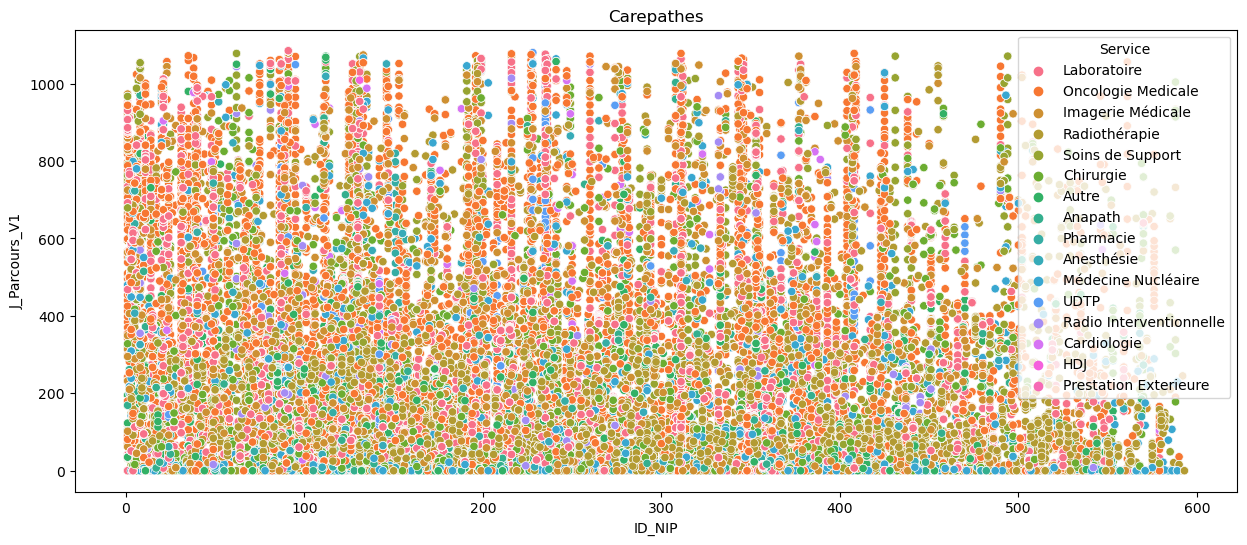

In [10]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP
"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

Mcftsc.plot_carepath(df_Actes_graph,myouputpath+ 'Actes_total.png')
mlflow.log_artifact(myouputpath+'Actes_total.png', "DS_General_plot")

AFFICHAGE DES PARCOURS RADIOTHERAPIE DES PATIENTS

2023-12-14 11:34:03,247 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'

2023-12-14 11:34:03,249 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


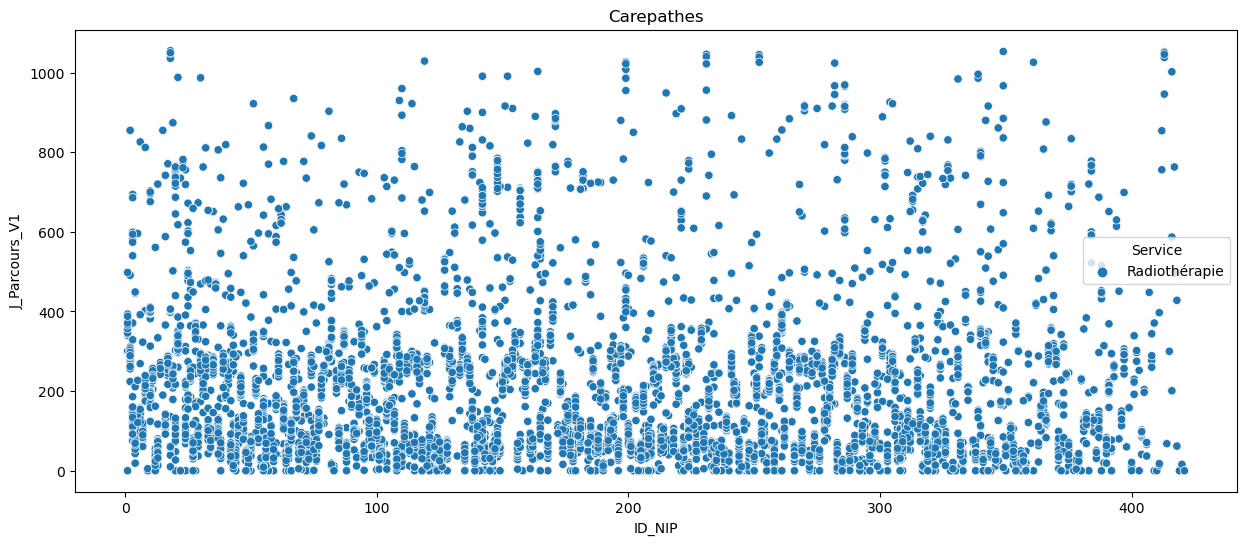

In [11]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'
"""
df_Actes_graph0=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

myoutputfile='Actes_rdth.png'
Mcftsc.plot_carepath(df_Actes_graph0,myouputpath + 'Actes_rdth.png')
mlflow.log_artifact(myouputpath + 'Actes_rdth.png', "DS_General_RDTH_plot")

## PARAMETRES D'AGGREGATION :

### creation d'un dictionnaire pour les multiples requetes d'aggrégation

Aggreg_parameters
    #PARAM1 = CHOICE = 
       	#-- 0 : REPORT DAYLY turnover from stardate of calendar (1 column = 1 DAY), CURSOR LINES ARE DAYS
		#-- 1 : REPORT WEEKLY turnover from stardate of calendar  (1 column = 1 WEEK), CURSOR LINES ARE WEEKS
		#-- 2 : REPORT MONTHLY turnover from stardate of calendar  (1 column = 1 month), CURSOR LINES ARE MONTHS
		#-- 3 : REPORT TRIMESTER turnover for the @YEAR (1 column = 3 months), CURSOR LINES ARE TRIMESTERS
		#-- 4 : REPORT ALL YEAR turnovers (1 column = 1 Year), CURSOR LINES ARE YEARS
    'Report_type': '2',  #--1

    #PARAM2 'TYPE AGGREG' --PARAMETER 3: @AggParameter as nvarchar(20)
		#--CALENDAR : Par date calendaire
		#--PARCOURS : Par date de parcours
    'Aggreg_type': 'PARCOURS',

    #Date ref
    'Date_ref' : "''",

    #0 --PARAMETER 4 : @AggParameter_min as int (NB jours)
    'Start_at_item': '0',

    #50 --PARAMETER 5 : @AggParameter_max as int (NB jours)
    'Stop_at_item': '36', # --104

    #'PRESENCE'	-- PARAMETER 4 : @AggMeth as nvarchar(20) --OK
		#--PRESENCE : -> FUNCTION COUNT
		#--COUNT -> FUNCTION SUM
		#--DENSITE -> Function SUM / Length of aggregation choice (1, 7, 30.41 , 365.25)
    'Method': 'COUNT',

    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20
          #--0-ALL
          #--1-SERVICE -> from Listing_UF_V3
          #--2-ACTIVITE -> from Listing_UF_V3
          #--3-PHASE PARCOURS -> from Listing_UF_V3
          #--4-DIMENSION PARCOURS -> from Listing_UF_V3
          #--5-POIDS ACTE -> from Listing_UF_V3
          #--6-TYPE DE SEQUENCE -> from Tmp_Type_Seq
          #--7-TYPE DE PARCOURS-- -> (After Clustering only)
          #--8-R_NGAP
          #--9-R_CCAM
          #--10-Statut
          #--11-UFH
          #--12-INX

    'Type_filter1': '6',
    'Val_filter1': 'TRAIT', #Filter value,
    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20)
    'Type_filter2': '1',
    'Val_filter2': 'Radiothérapie', #Filter value

    #J0
      #--V1
      #--V2
      #--V3
      #--V4"""
    'Param_J0':'V3'

In [12]:
Aggreg_parameters={'Report_type': '2',
                            'Aggreg_type': 'PARCOURS',
                            'Date_ref': "''",
                            'Start_at_item': '0',
                            'Stop_at_item': '6',
                            'Method': 'COUNT',
                            'Type_filter1': '6',
                            'Val_filter1': 'TRAIT',
                            'Type_filter2': '1',
                            'Val_filter2': 'Radiothérapie',
                            'Param_J0': 'V3',
                            }
#Tmp_Carac_Actes
#Tmp_A_Actes_Table_Analyse

Aggreg_parameters_TT_RDTH=Aggreg_parameters.copy()
Aggreg_parameters_TT_RDTH['Val_filter2']= 'Radiothérapie'

Aggreg_parameters_TT_CHIR=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIR['Val_filter2']= 'Chirurgie'

Aggreg_parameters_TT_CHIMIO=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIMIO['Val_filter2']= 'Oncologie Medicale'

Aggreg_parameters_TT_UDTP=Aggreg_parameters.copy()
Aggreg_parameters_TT_UDTP['Val_filter2']= 'UDTP'

Aggreg_parameters_TT_MN=Aggreg_parameters.copy()
Aggreg_parameters_TT_MN['Val_filter2']= 'Médecine Nucléaire'

Aggreg_parameters_TT_RI=Aggreg_parameters.copy()
Aggreg_parameters_TT_RI['Val_filter2']= 'Radio Interventionnelle'

Aggreg_parameters_TT_autre=Aggreg_parameters.copy()
Aggreg_parameters_TT_autre['Val_filter2']= 'Autre'


Aggreg_parameters_SUIVI_CT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_CT_CS['Val_filter1']= 'SUIVI_CT'
Aggreg_parameters_SUIVI_CT_CS['Type_filter2']= '3'
Aggreg_parameters_SUIVI_CT_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_SUIVI_LT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_LT_CS['Val_filter1']= 'SUIVI_LT'
Aggreg_parameters_SUIVI_LT_CS['Type_filter2']= '3'
Aggreg_parameters_SUIVI_LT_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_NEW_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_NEW_CS['Val_filter1']= 'INIT_NEW'
Aggreg_parameters_INIT_NEW_CS['Type_filter2']= '3'
Aggreg_parameters_INIT_NEW_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_OLD_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_OLD_CS['Val_filter1']= 'INIT_OLD'
Aggreg_parameters_INIT_OLD_CS['Type_filter2']= '3'
Aggreg_parameters_INIT_OLD_CS['Val_filter2']= 'Consultation'


In [13]:
#import importlib
#importlib.reload(Mcftsc)

In [14]:
#Define and save the aggregation parameters
Parameters_list=[Aggreg_parameters_TT_RDTH]
for param in Parameters_list:
    mlflow.log_params(param)

#Get the aggregation table
Aggreg_Patients=Mcftsc.get_Aggreg_Dataset2(Parameters_list)

#Save the aggregation table
Aggreg_Patients['df'].to_csv(myouputpath + 'Agg_Pat.csv')
mlflow.log_artifact(myouputpath + 'Agg_Pat.csv', "Aggreg_Dataset")

Number of aggregation dimensions: 1
2023-12-14 11:34:05,030 INFO sqlalchemy.engine.Engine EXECUTE [dbo].[ReportCarePathActivtiy_By_actes] 2,'PARCOURS','',0,6,'COUNT',6,'TRAIT',1,'Radiothérapie','V3'
2023-12-14 11:34:05,031 INFO sqlalchemy.engine.Engine [raw sql] ()


AlSQL_Requete - OK


## BOUCLE D'AGGREGATION

### AGGREGATION UNITAIRE

In [15]:
#AJOUTER ICI SI BESOIN UNE FONCTION DE POSTRAITEMENT DU DATASET AGGREG (F.Ex : MOBILE AVERAGE)

# 0- Courbe en l'état, présence au cours de l'aggrégat temporel.
# A developper ?
# 1- CUMUL DU NB DE SEJOURS DE TT RDTH, CHIR OU CHIMIO au cours du temps
# 2- Moyenne mobile sur (x mois/semaine) du nb de sejour de tt de RDTH, CHIR OU CHIMIO


#PREPARER AU PASSAGE EN :

#- FONCTION DE CLUSTERING DE PARCOURS
    #INPUTS : 
        
        #CLUSTER 1 (TIME WINDOW)
            # TABLE DE CLUSTERING (Dist_matrix)
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM) (Cluster 1 on Time Window)
            # NOM DE LA DIMENSION DE CLUSTERING (Cluster 1 on Time Window)
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ?  (Cluster 1 on Time Window)
        #CLUSTER 2 (PARCOURS DIMENSION)
            # TABLE DE CLUSTERING (Dist_matrix) avec les lignes correspondant aux index des identifiants du DF 'Aggreg'
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM)
            # NOM DE LA DIMENSION DE CLUSTERING 
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ? 

    #OUTPUTS:
        #CLUSTER 1 (TIME WINDOW)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG

        #CLUSTER 2 (PARCOURS DIMENSION)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG
            # GET THE MEAN INDIVIDUAL
            # SUMMARY OF THE CLUSTERING (TABLE WITH CLUSTER POPULATION, MEAN, VARIANCE) ON THE PARAMETER CLUSTERED



#- FONCTION DE PLOT 
#- FONCTION DE LOG MLFLOW

#### PREPARATION CLUSTERING DE FENETRE TEMPORELLE

In [16]:
# AJOUTER DES VARIABLES D'INTERET DU PATIENT
#Date de la dernière activitée ?

date_format = '%m-%d-%Y %H:%M:%S'

DPA_ref=datetime.strptime(Create_dataset_parameters['DS_Start_Window_time'], date_format)
DDA_ref=datetime.strptime(Create_dataset_parameters['DS_End_Window_time'], date_format)

DPA_ref = pd.to_datetime(DPA_ref)
DPA_ref = pd.to_datetime(DPA_ref)


#Calcul des distances entre les bornes de fenêtre temporelle et premier et dernier acte
Requete="""SELECT [NIP]
	  ,MIN([DD_A]) DPA_NIP
      ,MAX([DF_A]) DDA_NIP
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  GROUP BY NIP
"""
CP_Bounds_NIP=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

CP_Bounds_NIP['DPA_NIP'] = pd.to_datetime(CP_Bounds_NIP['DPA_NIP'])
CP_Bounds_NIP['DDA_NIP'] = pd.to_datetime(CP_Bounds_NIP['DDA_NIP'])

CP_Bounds_NIP.DPA_NIP=(CP_Bounds_NIP['DPA_NIP'] - DPA_ref).dt.days
CP_Bounds_NIP.DDA_NIP=( DDA_ref - CP_Bounds_NIP['DDA_NIP']).dt.days

#integration au dataset Aggregpatient
Aggreg_Patients['df'] = pd.merge(Aggreg_Patients['df'],CP_Bounds_NIP, on='NIP')

#Création d'une matrice concaténée entre dist_matrix et CP_bounds
agg_func = { 
    'DPA_NIP': 'min',
    'DDA_NIP': 'min'
}
#print(Aggreg_Patients2)
DDA_Clust=Aggreg_Patients['df'][['NIP','DPA_NIP','DDA_NIP']].groupby('NIP').agg(agg_func)
print(DDA_Clust[['DPA_NIP','DDA_NIP']])

2023-12-14 11:34:10,579 INFO sqlalchemy.engine.Engine SELECT [NIP]
	  ,MIN([DD_A]) DPA_NIP
      ,MAX([DF_A]) DDA_NIP
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  GROUP BY NIP

2023-12-14 11:34:10,580 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
            DPA_NIP  DDA_NIP
NIP                         
N198300511      275       21
N198412339      139      378
N198502208      206      553
N198510292      238       57
N198600228      307      357
...             ...      ...
N201900013      358      258
N201900014      358      554
N201900015      358        8
N201900016      358       98
N201900017      358       15

[593 rows x 2 columns]


#### CLUSTERING DE LA FENETRE TEMPORELLE

In [17]:
# TABLE TO BE CLUSTERED
X=DDA_Clust

#METHODE DE CLUSTERING
Method="KMeans"

# Nombre de clusters que vous souhaitez tester
n_clusters1 = None  #(can be None if you want automatic clustering)
max_clusters = 20 #(by default)
threshold = 0.05

#DIMENSION NAME
clust_prefix = "Clust_Time_"
clust_suffix = "1"
image_format = ".png"

#Filename
mypath= myouputpath
curve_filename= mypath + clust_prefix + clust_suffix + "_curve" + image_format
curve_mlflowname= clust_prefix + clust_suffix +"_curve"

PCA_filename = mypath + clust_prefix + clust_suffix + "_PCA" + image_format
PCA_mlflowname= clust_prefix + clust_suffix + "_PCA"


#mlflowoutput
mlflow_NB_Clust={'curve_filename' : curve_filename , 'curve_mlflowname' : curve_mlflowname}
mlflow_PCA={'curve_filename' : PCA_filename , 'curve_mlflowname' : PCA_mlflowname}

#Show output
ouput=True

In [18]:
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
def optimal_nb_cluster(inertia,threshold,max_clusters):
    optimal_nb_cluster = None  # Initialiser à None pour indiquer qu'aucune valeur optimale n'est encore trouvée
    for i in range(1, max_clusters):  # Commencer à 1 car la différence est calculée entre i et i-1
        if abs(inertia[i] - inertia[i - 1]) / inertia[0] < threshold:
            optimal_nb_cluster = i
            break  # Sortir de la boucle lorsque la condition est satisfaite*
    return optimal_nb_cluster

In [20]:
def Automatic_nb_cluster(X_scaled,Method, max_clusters,ouput=None,mlflow=None,mlflow_output=None):
    #APPLY CLUSTERING
    if Method=="KMeans" :
        from sklearn.cluster import KMeans
        # Liste pour stocker les valeurs de l'inertie
        inertia = []

        for n_clusters in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

    elif Method=="AgglomerativeClustering":
        print('No method implemented !!')

    nb_clusters = optimal_nb_cluster(inertia,threshold,max_clusters)

    curve_filename=mlflow_output['curve_filename']
    curve_mlflowname=mlflow_output['curve_mlflowname']

    # Tracer le graphique de l'inertie en fonction du nombre de clusters
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
    
    if mlflow!=None:
        plt.savefig(curve_filename)
        #MLFLOW LOG
        #Curve of nb of cluster
        mlflow.log_artifact(curve_filename, curve_mlflowname)
        #PLot of the clustering 
        mlflow.log_artifact(PCA_filename, PCA_mlflowname)
        
    if ouput!=None:
        plt.show()
    
    return nb_clusters

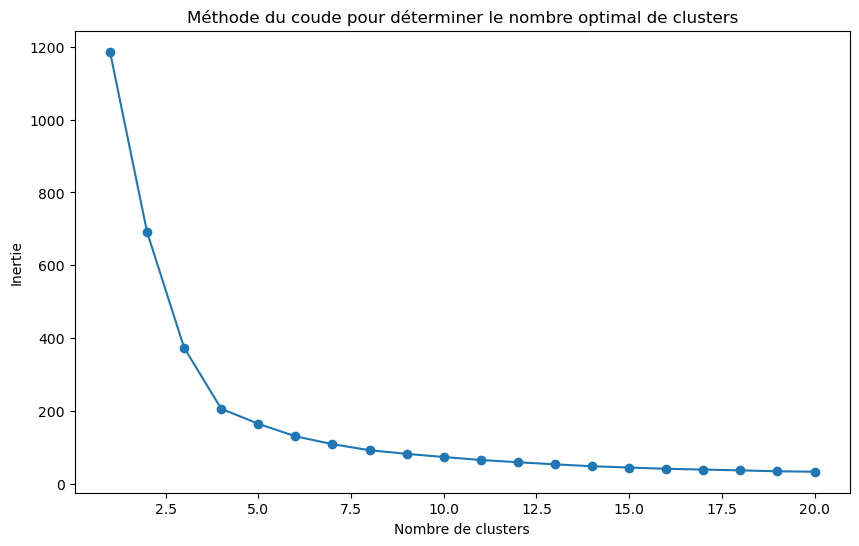

In [21]:
if n_clusters1==None:
    n_clusters1=Automatic_nb_cluster(X_scaled,Method, max_clusters,ouput,mlflow,mlflow_NB_Clust)
    mlflow.log_metrics({'Optimal_nb_clust_time': n_clusters1})

#nb of clusters
mlflow.log_params({'nb_clust1': n_clusters1})


0    203.0
1    202.0
2     87.0
3    101.0
Name: Cluster2, dtype: float64


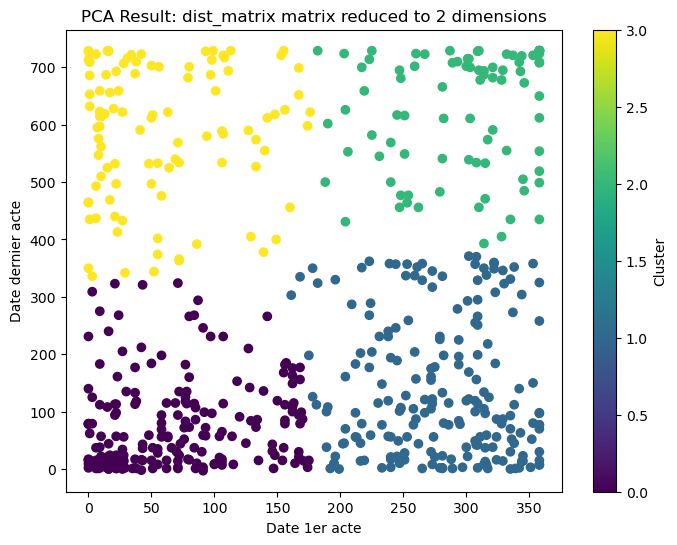

In [22]:
#APPLY CLUSTERING
if Method=="KMeans" :
    from sklearn.cluster import KMeans
    clust = KMeans(n_clusters=n_clusters1)
elif Method=="AgglomerativeClustering":
    from sklearn.cluster import AgglomerativeClustering
    clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

#PREDICT THE CLUSTER ON THE DATASET
labels = clust.fit_predict(X_scaled)
Labels_duplicated=[]



#ADAPT THE LABEL SIZE IF MULTIDIMENSIONNAL TS CLUSTERING
for i in range(len(labels)):
    for k in range(int(Aggreg_Patients['Nb_dim'])):
        Labels_duplicated.append(labels[i])
    
#Applique le n° de CLUSTER aux dataset initiaux
Aggreg_Patients['df']['Cluster2']=Labels_duplicated

#Show how the clusters are populated
cluster_counts = Aggreg_Patients['df']['Cluster2'].value_counts().sort_index()
cluster_counts_divided = cluster_counts.divide(int(Aggreg_Patients['Nb_dim']))
print(cluster_counts_divided)



# Plotting the PCA result with cluster colors
plt.figure(figsize=(8, 6))
plt.scatter(DDA_Clust['DPA_NIP'], DDA_Clust['DDA_NIP'], c=labels, cmap='viridis')
plt.title('PCA Result: dist_matrix matrix reduced to 2 dimensions')
plt.xlabel('Date 1er acte')
plt.ylabel('Date dernier acte')
plt.colorbar(label='Cluster')
plt.savefig(PCA_filename)

if ouput:
    plt.show()

In [23]:
#MLFLOW LOG

#Curve of nb of cluster
mlflow.log_artifact(curve_filename, curve_mlflowname)

#nb of clusters
mlflow.log_params({'nb_clust1': n_clusters1})

#PLot of the clustering 
mlflow.log_artifact(PCA_filename, PCA_mlflowname)

#### PREPARATION CLUSTERING DE PARCOURS - CREATION DE COURBES CARACTERISTIQUES DE PARCOURS

In [24]:
# Calcul des distances entre courbes de parcours
dist_matrix=Mcftsc.GetDistanceMatrix(Aggreg_Patients, Aggreg_parameters)

#EXPORT DE LA MATRICE DE DISTANCE
#dist_matrix.tofile(myouputpath + "Matrice_distance.dat")
np.savetxt(myouputpath + "distance_matrix.csv",dist_matrix,delimiter=",")
mlflow.log_artifact(myouputpath + "distance_matrix.csv", "Matrice de distance inter-Parcours")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Iteration 0/592 - Temps restant estimé: 0.89 minutes
Iteration 100/592 - Temps restant estimé: 0.49 minutes
Iteration 200/592 - Temps restant estimé: 0.36 minutes
Iteration 300/592 - Temps restant estimé: 0.24 minutes
Iteration 400/592 - Temps restant estimé: 0.14 minutes
Iteration 500/592 - Temps restant estimé: 0.06 minutes
Durée totale de traitement: 19.13 secondes


#### CLUSTERING DES FONCTIONS DE PARCOURS


In [25]:
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist_matrix)

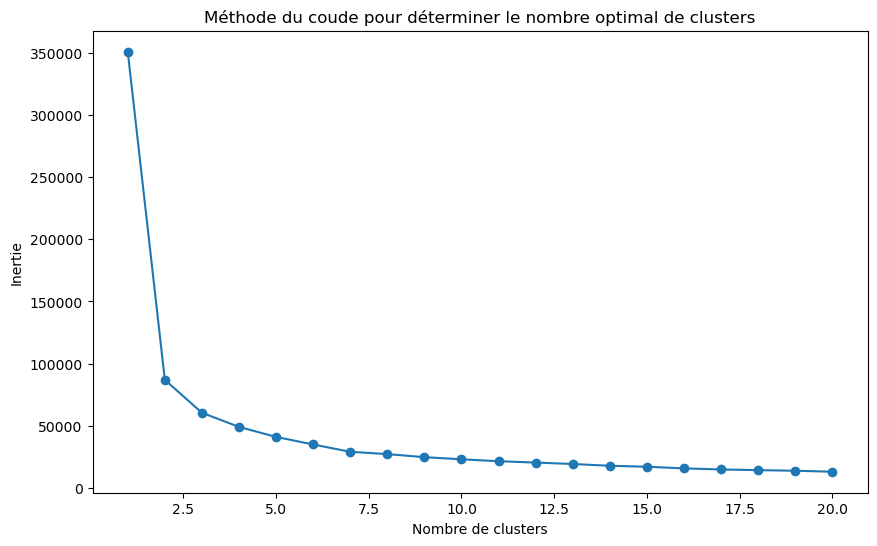

In [26]:
#IDENTIFIER LE MEILLEUR NB DE CLUSTER

from sklearn.cluster import KMeans

# Liste pour stocker les valeurs de l'inertie
inertia = []

# Nombre de clusters que vous souhaitez tester
max_clusters = 20

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.savefig(myouputpath + 'Clust_2_curve.png')
mlflow.log_artifact(myouputpath + 'Clust_2_curve.png', "Clust_2_curve")
plt.show()

   Cluster  NIP_Count  Mean_dist_Variance
0        0        448            1.843771
1        1         65           16.659256
2        2         19           72.486756
3        3         61            4.025977


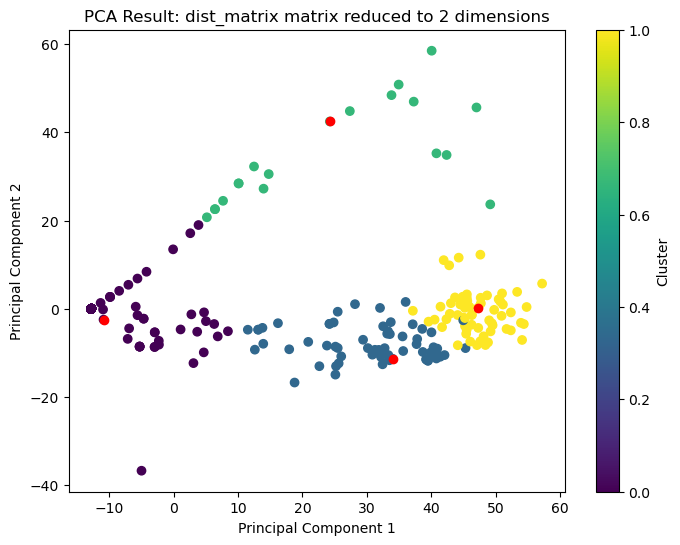

In [27]:
n_clusters2 = 4  # Choose the number of clusters you want


#APPLY CLUSTERING AGGLOMERATIVE
#from sklearn.cluster import AgglomerativeClustering
#clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

#APPLY CLUSTERING KMEANS
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=n_clusters2)


from sklearn.mixture import GaussianMixture
#clust = GaussianMixture(n_components=n_clusters)  # No n_components specified
#clust = GaussianMixture(n_components=10, covariance_type='tied')

labels = clust.fit_predict(X_scaled)


#Applique le n° de CLUSTER aux dataset initiaux

Labels_duplicated=[]

for i in range(len(labels)):
    for k in range(int(Aggreg_Patients['Nb_dim'])):
        Labels_duplicated.append(labels[i])
    
Aggreg_Patients['df']['Cluster']=Labels_duplicated

cluster_means = Aggreg_Patients['df'].groupby('Cluster').mean()
cluster_var = Aggreg_Patients['df'].groupby('Cluster').sem()

#Compute the clusters description and define the 'mean individual'

# Get the "mean individual" from each cluster.
df_dist_matrix = pd.DataFrame(dist_matrix)
df_dist_matrix['Cluster'] = labels
df_dist_matrix['NIP'] = Aggreg_Patients['df']['NIP']
df_dist_matrix['Mean_Indiv'] = False


for cluster in range(n_clusters2):
    # Extract a part of the dist matrix
    cluster_subset = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]

    # Compute the mean distance for each row in the cluster and store it in the 'Mean_dist' column
    df_dist_matrix.loc[df_dist_matrix['Cluster'] == cluster, 'Mean_dist'] = cluster_subset.drop(['Cluster', 'NIP', 'Mean_Indiv'], axis=1).mean(axis=1)

    # Calculate the mean of the distances within the cluster
    mean_distance = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]['Mean_dist'].mean()

    # Find the index of the row closest to the mean distance
    mean_row_mean_index = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]['Mean_dist'].sub(mean_distance).abs().idxmin()

    # Update 'Mean_Indiv' to True for the row with the minimum mean distance
    df_dist_matrix.at[mean_row_mean_index, 'Mean_Indiv'] = True

# Creating the Clustering_summary DataFrame
# Group by 'Cluster' and calculate count of 'NIP' and variance of 'Mean_dist'
summary_data = df_dist_matrix.groupby('Cluster').agg({'NIP': 'count', 'Mean_dist': 'var'}).reset_index()
summary_data.columns = ['Cluster', 'NIP_Count', 'Mean_dist_Variance']

# Creating the Clustering_summary DataFrame
Clustering_summary = summary_data.copy()

# Displaying the summary DataFrame
print(Clustering_summary)

#import numpy as np
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt


#labels   # Example cluster labels, replace this with your actual cluster labels
# Assuming dist_matrix is your 50x50 matrix
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X_scaled)


indices_to_highlight=df_dist_matrix.loc[df_dist_matrix['Mean_Indiv'] == True].index


# Plotting the PCA result with cluster colors
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.scatter(pca_result[indices_to_highlight, 0], 
            pca_result[indices_to_highlight, 1], 
            c='red', label='Highlighted Points')

plt.title('PCA Result: dist_matrix matrix reduced to 2 dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.savefig(myouputpath + 'Clust_2_shape.png')
plt.show()




In [28]:
#Store to mlflow important values
mlflow.log_params({'nb_clust2': n_clusters2})
mlflow.log_artifact(myouputpath + 'Clust_2_shape.png', "Clust_2_2D")

cluster_means.to_csv(myouputpath + 'Cluster_means.csv')
cluster_var.to_csv(myouputpath + 'Cluster_var.csv')

mlflow.log_artifact(myouputpath + 'Cluster_means.csv', 'cluster means')
mlflow.log_artifact(myouputpath + 'Cluster_var.csv','cluster var')
mlflow.log_table(Clustering_summary,'cluster summary')

df_dist_matrix.to_excel(myouputpath + 'DF_dist_matrix.xlsx')
mlflow.log_artifact(myouputpath + 'DF_dist_matrix.xlsx', 'DF_dist_matrix.xlsx')

#### PLOT CLUSTERS PARCOURS CURVE

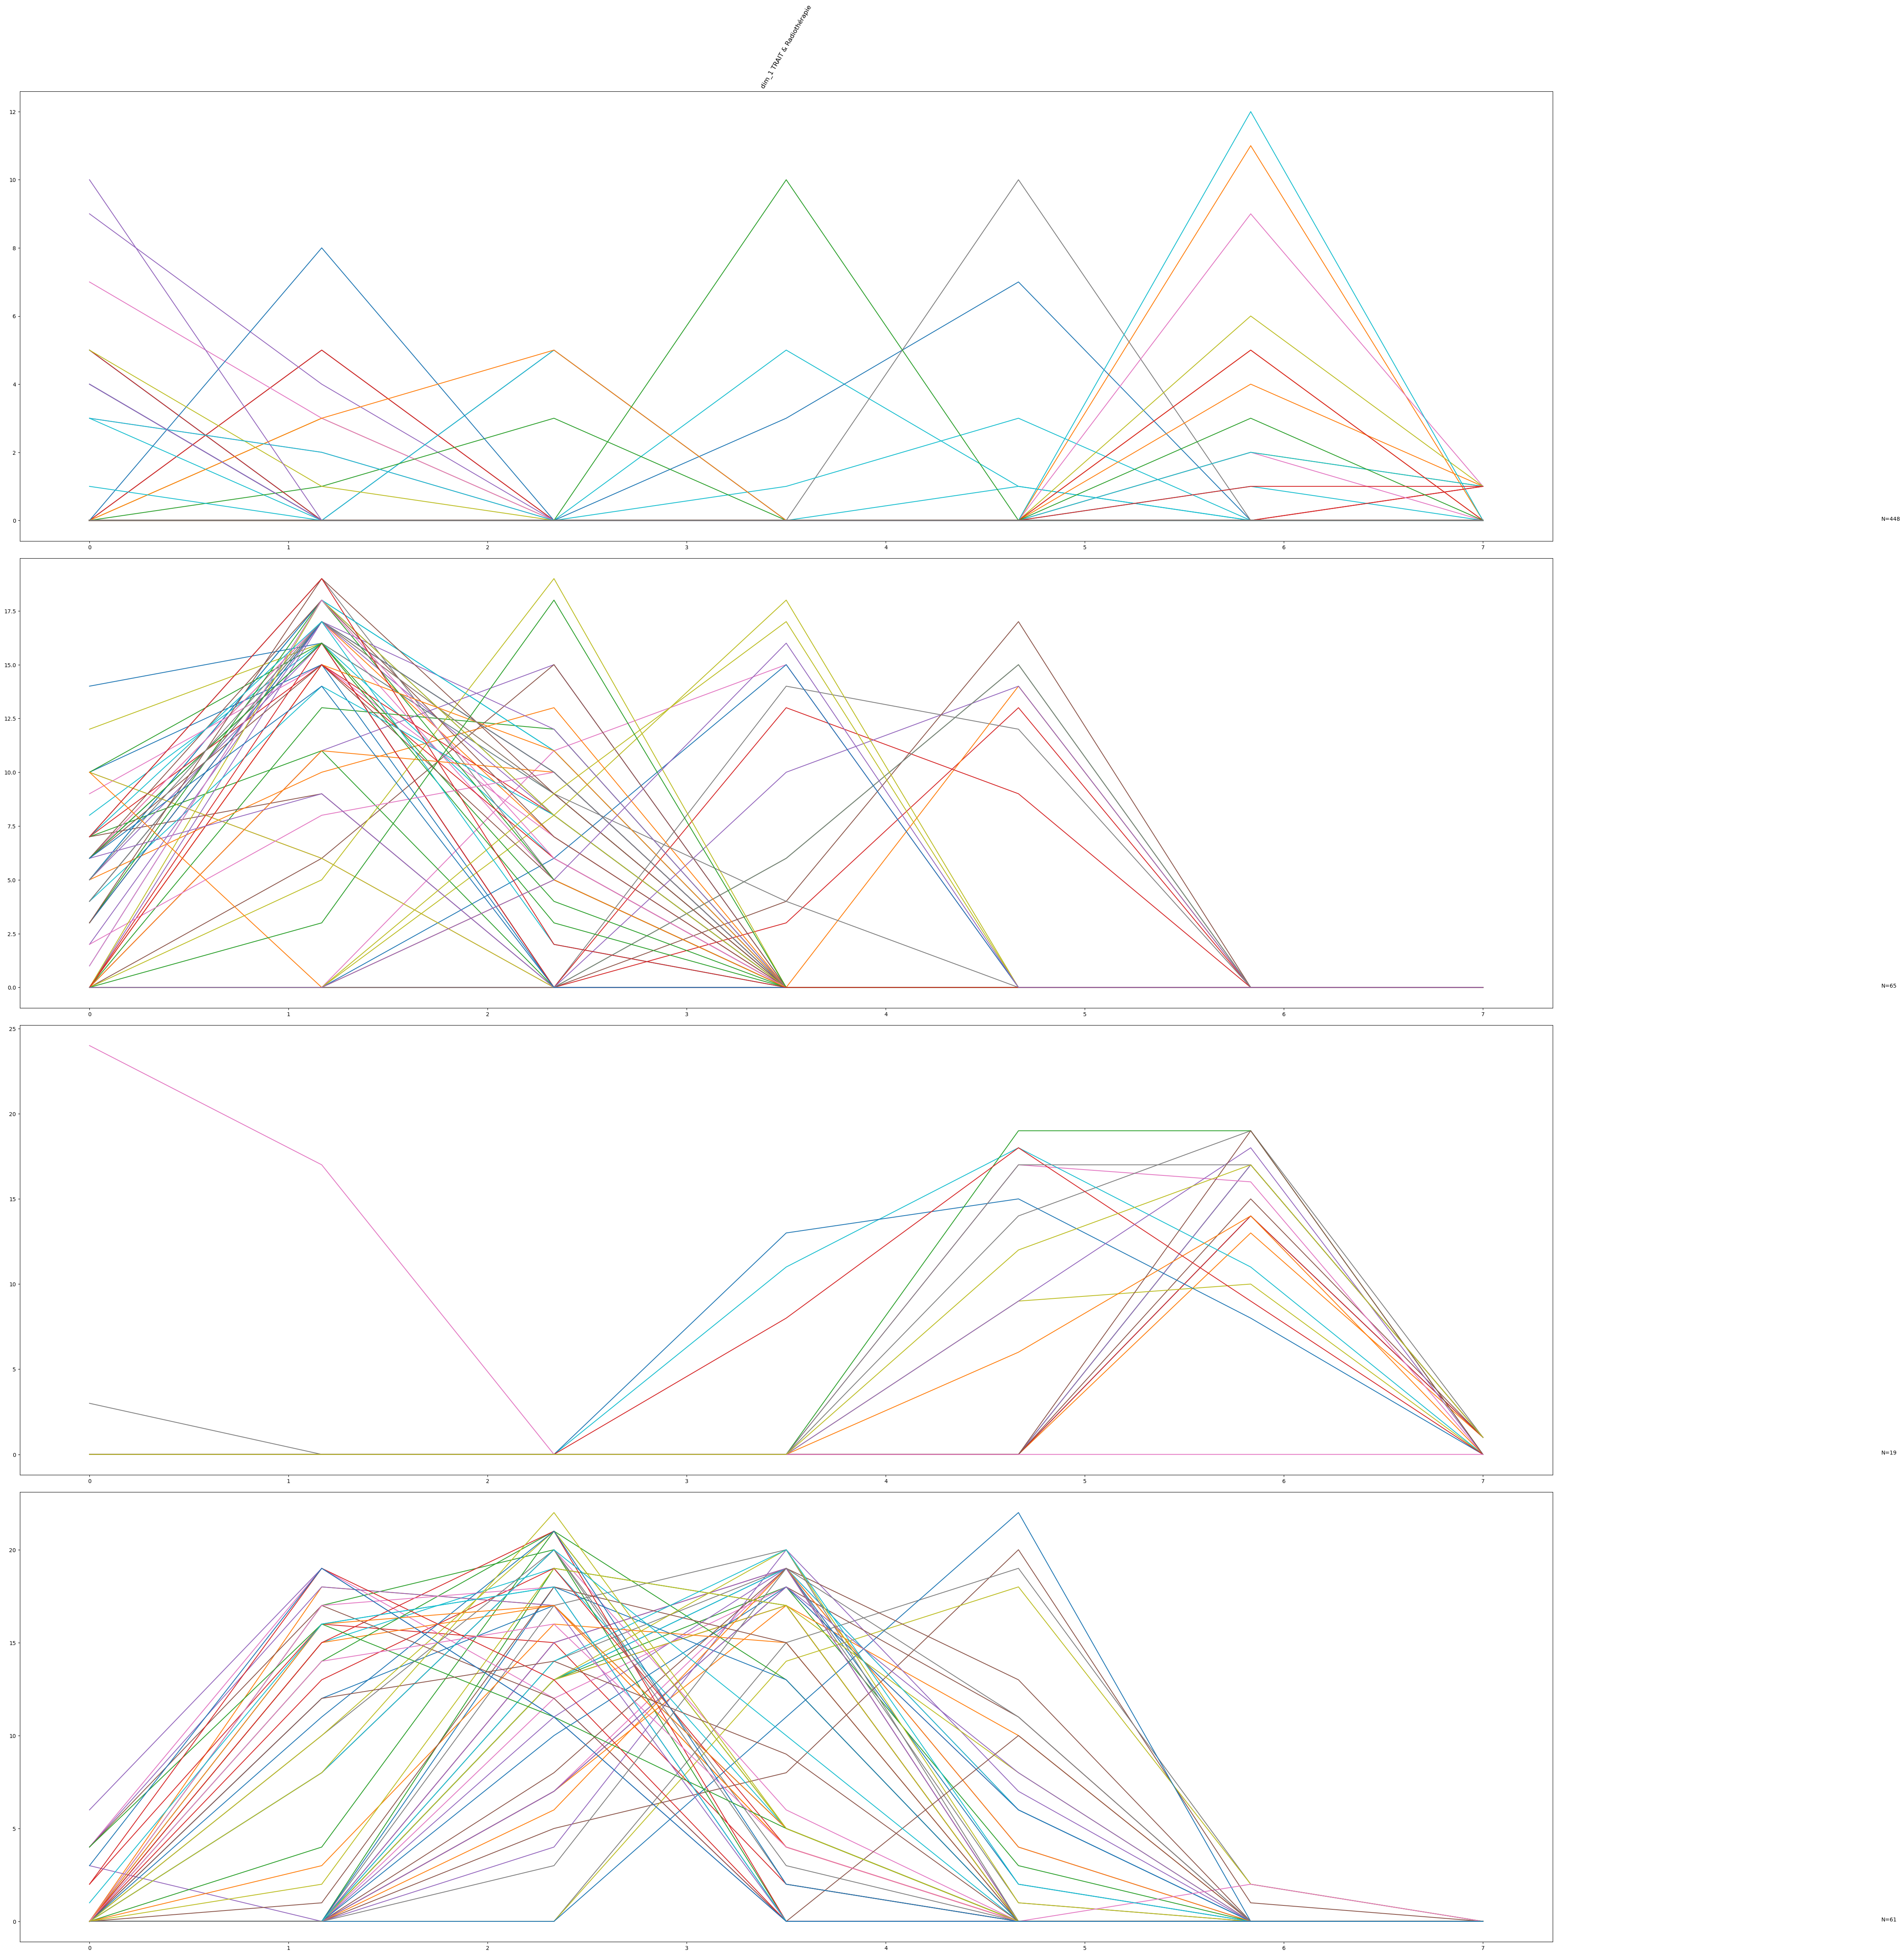

In [29]:
Mcftsc.plot_TS_clusters(Aggreg_Patients,Aggreg_parameters,myouputpath+ 'TS_curves.png',n_clusters2 )


#### PLOT MEAN INDIVIDUAL

#### PLOT LE CLUSTERING DE PARCOURS

ORDER THE CAREPATHES BY TIME
UNE ALTERNATIVE SERAIT DE PRENDRE LE PARCOURS MOYEN DU CLUSTER ET DE CLASSER PAR DISTANCE D'ECART AU PARCOURS MOYEN.

In [30]:
df_time_feature1=pd.merge(df_Actes_graph[['NIP','J_Parcours_V1','J_Parcours_V3']],Aggreg_Patients['df'][['NIP','Cluster','Cluster2']], on='NIP',how='left')
df_time_feature1=df_time_feature1.sort_values(by=['Cluster','Cluster2','J_Parcours_V3','NIP']).copy()
df_time_feature1[['NIP','J_Parcours_V1','J_Parcours_V3']]
df_time_feature1

NIP  J_Parcours_V1  J_Parcours_V3  Cluster  Cluster2
14047  N201800012              0              0        0         0
14048  N201800012              0              0        0         0
21570  N201800626              0              0        0         0
26116  N201800626              0              0        0         0
66009  N201800626              0              0        0         0
...           ...            ...            ...      ...       ...
32945  N201800916            329            329        3         3
32946  N201800916            329            329        3         3
32947  N201800916            329            329        3         3
32960  N201800916            329            329        3         3
32873  N201800916            330            330        3         3

[105804 rows x 5 columns]

In [31]:
agg_functions_max = { 
    'J_Parcours_V1': 'max',
    'J_Parcours_V3': 'max',
    'Cluster': 'max',
    'Cluster2': 'max'
}
agg_functions_min = { 
    'J_Parcours_V1': 'min',
    'J_Parcours_V3': 'min',
}
df_time_feature_max = df_time_feature1.groupby('NIP').agg(agg_functions_max)
df_time_feature_max = df_time_feature_max.rename(columns={'J_Parcours_V1': 'Max_J_V1','J_Parcours_V3': 'Max_J_V3'})

df_time_feature_min = df_time_feature1[['NIP','J_Parcours_V1','J_Parcours_V3']].groupby('NIP').agg(agg_functions_min)
df_time_feature_min = df_time_feature_min.rename(columns={'J_Parcours_V1': 'Min_J_V1','J_Parcours_V3': 'Min_J_V3'})
df_time_feature1 = pd.concat([df_time_feature_min, df_time_feature_max], axis=1)

df_time_feature1

Min_J_V1  Min_J_V3  Max_J_V1  Max_J_V3  Cluster  Cluster2
NIP                                                                  
N198300511         0     12886       791     13677        0         1
N198412339         0     12384       570     12954        0         3
N198502208         0     12086       328     12414        0         2
N198510292         0     12118       792     12910        0         1
N198600228         0     11822       423     12245        0         1
...              ...       ...       ...       ...      ...       ...
N201900013         0         0       471       471        0         1
N201900014         0         0       175       175        0         2
N201900015         0         0       721       721        3         1
N201900016         0         0       631       631        1         1
N201900017         0         0       714       714        0         1

[593 rows x 6 columns]

In [32]:
#Ordonner le dataset
df_time_feature1['NIP']=df_time_feature1.index
df_time_feature1.reset_index(drop=True, inplace=True)
df_time_feature1.sort_values(['Cluster','Cluster2', 'Max_J_V1'], ascending=[True,True, False], inplace=True)

In [33]:
# Creation de l'abscisee du graph

Nb_NIP=len(df_time_feature1)

#First STEP
old_NIP=''
old_Cluster=-1
old_Cluster2=-1
x_values=[]
xx_values=[]
x=0
NIP_Step = 100/Nb_NIP

for index,row in df_time_feature1.iterrows():
    
    if old_Cluster!=row['Cluster']:
        x += NIP_Step
        x_values.append(x)  #crée une nouvelle ligne verticale de Cluster N1
        df_time_feature1.at[index,'X_abscisse']=x
    elif old_Cluster2!=row['Cluster2']:
        x += NIP_Step
        xx_values.append(x) #crée une nouvelle ligne verticale de Cluster N2
        df_time_feature1.at[index,'X_abscisse']=x
    else:    
        x += NIP_Step
        df_time_feature1.at[index,'X_abscisse']=x
       


    df_time_feature1.at[index,'X_abscisse']=x
    old_NIP=row['NIP']
    old_Cluster=row['Cluster']
    old_Cluster2=row['Cluster2']

# Afficher le DataFrame avec les abscisses calculées
df_time_feature1

Min_J_V1  Min_J_V3  Max_J_V1  Max_J_V3  Cluster  Cluster2         NIP  \
264         0         0      1085      1085        0         0  N201800012   
106         0      2024      1080      3104        0         0  N201203100   
60          0      3487      1078      4565        0         0  N200802092   
131         0      1654      1078      2732        0         0  N201307669   
238         0       192      1078      1270        0         0  N201704974   
..        ...       ...       ...       ...      ...       ...         ...   
505         0         0       245       245        3         2  N201806465   
470         0         0       194       194        3         2  N201805973   
399         0         0       170       170        3         2  N201804663   
545         0         0        81        81        3         2  N201806902   
276         0         0       330       330        3         3  N201800916   

     X_abscisse  
264    0.168634  
106    0.337268  
60     0.505902  
131    0.674536  
238    0.843170  
..          ...  
505   99.325464  
470   99.494098  
399   99.662732  
545   99.831366  
276  100.000000  

[593 rows x 8 columns]

In [34]:
#Sauvegarder dans la BDD l'association NIP - Cluster
Table_Cluster='Tmp_NIP_Cluster' 
Requete = 'EXECUTE dbo.Delete_Table_if_exists ' + Table_Cluster
with AlSQL.engine.begin() as conn:
            conn.execute(sqlalchemy.text(Requete))
df_time_feature1[['NIP','Cluster','Cluster2','X_abscisse']].to_sql(Table_Cluster,AlSQL.engine)

df_time_feature1[['NIP','Cluster','Cluster2','X_abscisse']].to_csv(myouputpath + 'Cluster1_2_abscisses.csv')
mlflow.log_artifact(myouputpath + 'Cluster1_2_abscisses.csv', "Cluster Ouput")

2023-12-14 11:35:33,058 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-14 11:35:33,058 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_NIP_Cluster
2023-12-14 11:35:33,060 INFO sqlalchemy.engine.Engine [generated in 0.00175s] ()
2023-12-14 11:35:33,063 INFO sqlalchemy.engine.Engine COMMIT
2023-12-14 11:35:33,072 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-14 11:35:33,073 INFO sqlalchemy.engine.Engine [generated in 0.00088s] ('Tmp_NIP_Cluster', 'dbo')
2023-12-14 11:35:33,077 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-14 11:35:33,079 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_NIP_Cluster] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cluster] INTEGER NULL, 
	[Clu

2023-12-14 11:35:33,406 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  ,Table_Cluster.Cluster
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
        AND Table_Acte.[Phase]='Traitement'
  ORDER BY Table_Cluster.Cluster asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]

2023-12-14 11:35:33,407 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


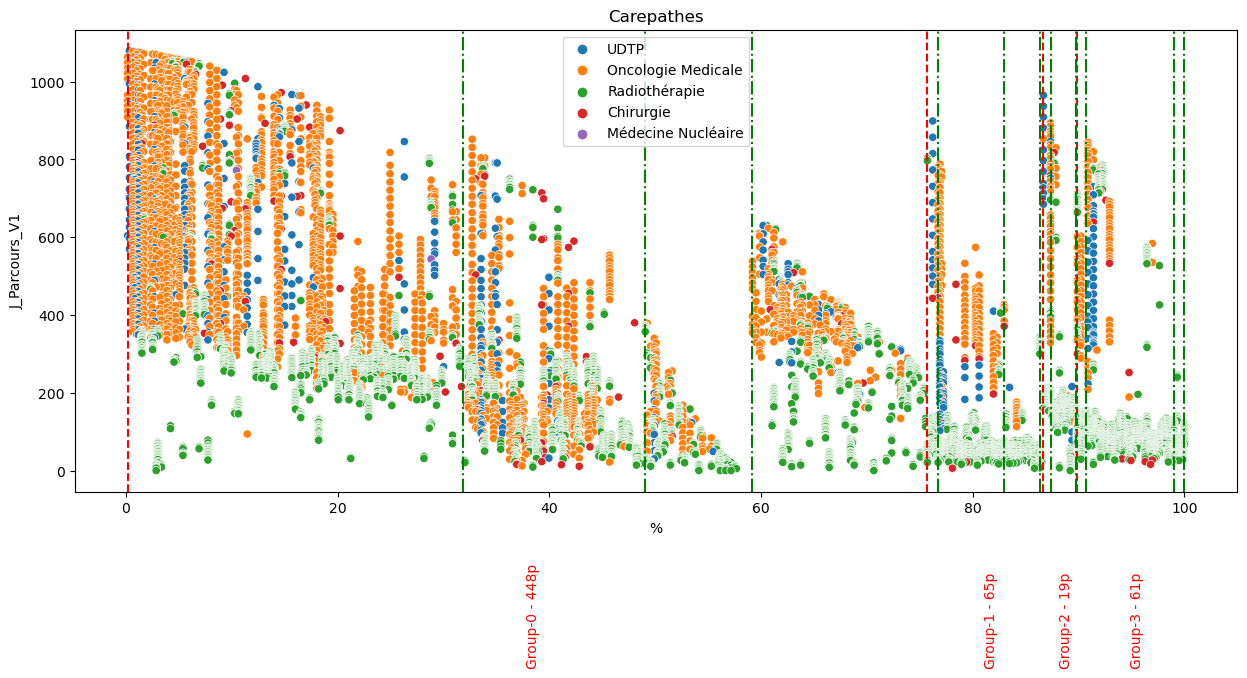

In [35]:
#Recuperer une table acte avec les clusters
Requete="""SELECT Table_Acte.[NIP]
	  ,Table_Cluster.Cluster
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
        AND Table_Acte.[Phase]='Traitement'
  ORDER BY Table_Cluster.Cluster asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
"""
df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')


fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.set_title('Carepathes')
scatter=sns.scatterplot(data=df_Actes_graph2, x=df_Actes_graph2.X_abscisse, y='J_Parcours_V1',markers='Activite', hue='Service')

# Changing X and Y axis labels
scatter.set_xlabel('%')  # Change X axis label
scatter.set_ylabel('J_Parcours_V1')  # Change Y axis label

# Ajoutez la ligne verticale
for x_value in x_values:
    axs.axvline(x=x_value, color='red', linestyle='--') #, label=f'Vertical Line at x={x_value}')

# Ajoutez la ligne verticale
for xx_value in xx_values:
    axs.axvline(x=xx_value, color='green', linestyle='-.') #, label=f'Vertical Line at x={x_value}')

#Ajouter le n° de cluster + sa taille*
pop_clust=df_time_feature1['Cluster'].value_counts().sort_index()
x_text=[0]*n_clusters2

for n_clus in range(n_clusters2):    
    if n_clus==0 :
        x_text[n_clus]=NIP_Step * pop_clust[n_clus] / 2
    else:
        x_text[n_clus]=x_text[n_clus-1] + NIP_Step*(pop_clust[n_clus-1] + pop_clust[n_clus])/2
    y_text=(-500)
    axs.text(x_text[n_clus], y_text, 'Group-' + str(n_clus) + " - " + str(pop_clust[n_clus]) +"p", color='red', rotation=90)
    

# Vous pouvez personnaliser la couleur, le style de ligne, et ajouter une légende
axs.legend()

#Enregistre le graph dans mlflow.
plt.savefig(myouputpath + 'Parcours_clustered_shape.png')
mlflow.log_artifact(myouputpath + 'Parcours_clustered_shape.png', "Carepath_Clustered")

plt.show()

#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

## INTERSECTION DE TOUTES LES AGGREGATIONS ET CLUSTERING

In [36]:
# ADD HERE THE RESULT PLOT OF THE INTERSECTION OF ALL CLUSTERING DIMENSIONS.

## FIN DU PROGRAMME

In [37]:
# CLOSE THE MLFLOW
mlflow.end_run()